In [1]:
import sys
import copy
import functools

import torch
import torch.nn as nnexit
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import random
import math

from dataset import binary_counter_1d
from architecture import Cnn1dReLUAvg

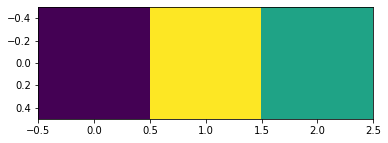

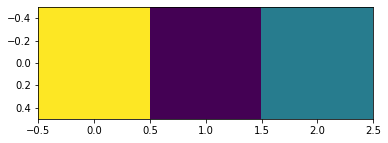

In [88]:
# noisy mode --- requires director and noise

pattern_size = 3
director = torch.randn( pattern_size)
director /= director.norm()
plt.imshow(director.reshape(1,-1))
plt.show()

plt.imshow(-director.reshape(1,-1))
plt.show()

noise = 0.1

set_size = 1024
x_train, y_train = binary_counter_1d( set_size, 6, 3, 1, 'noisy', director=director, noise=noise, exclusion=True, centered=True)
x_test, y_test = binary_counter_1d( 512, 6, 3, 1, 'noisy', director=director, noise=noise, exclusion=True, centered=True)

In [91]:
hidden = 1
filter_size = 3
bias = True
pbc = False
stride = 3
model = Cnn1dReLUAvg(hidden, filter_size, bias=bias, pbc=pbc, stride=stride)
model_init = copy.deepcopy(model)

class HingeLoss(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, output, target):
        hinge_loss = 1 - output*target
        return F.relu(hinge_loss)

class HingeLoss_a(torch.nn.Module):

    def __init__(self, alpha):
        super(HingeLoss_a, self).__init__()

        self.alpha = alpha

    def forward(self, output, target):
        hinge_loss = 1 - self.alpha*output*target
        return F.relu(hinge_loss).mean(dim=1) / self.alpha

class ScalarTestError(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, output, target):
        error = ( 1 - torch.sign( (output*target)))*0.5
        return  error.mean()

loss_f = HingeLoss_a(1.0)
test_f = ScalarTestError()

In [92]:
from gradientflow import gradientflow_backprop

dynamics = []
for state, internals in gradientflow_backprop(model, x_train, y_train, loss_f, subf0=True, max_dgrad=1e10, max_dout=1e-1):

    if state['step'] % 10 == 0:

        with torch.no_grad():
            out = internals['f'](x_test)
        test = ( out - model_init(x_test))
        testerr = test_f(test, y_test).item()

        current = state
        current['test'] = testerr
        print(current)
        dynamics.append(current)

        if state['loss'] < 0.0:
            break

        if state['t'] > 1e7:
            break

        if state['step'] > 1000:
            break

{'step': 0, 't': 0, 'loss': 1.0, 'dt': 0, 'dgrad': 0, 'dout': 0, 'test': 0.5}
{'step': 10, 't': 2.3579476910000006, 'loss': 0.9305604100227356, 'dt': 0.2143588810000001, 'dgrad': 0.0033567866776138544, 'dout': 0.03399607539176941, 'test': 0.501953125}
{'step': 20, 't': 4.374113222137242, 'loss': 0.7434809803962708, 'dt': 0.03452271214393103, 'dgrad': 9.130890248343349e-05, 'dout': 0.013709664344787598, 'test': 0.501953125}
{'step': 30, 't': 4.979336656134764, 'loss': 0.6364738345146179, 'dt': 0.0895430243255239, 'dgrad': 1.2498146295547485, 'dout': 0.04586029052734375, 'test': 0.501953125}
{'step': 40, 't': 6.176581512611856, 'loss': 0.5731359720230103, 'dt': 0.14420993610649954, 'dgrad': 0.9051560163497925, 'dout': 0.0178525447845459, 'test': 0.501953125}
{'step': 50, 't': 7.252827143290724, 'loss': 0.5581671595573425, 'dt': 0.030912680532870763, 'dgrad': 0.014018252491950989, 'dout': 0.0018455684185028076, 'test': 0.501953125}
{'step': 60, 't': 7.794762510018896, 'loss': 0.5518448948

{'step': 560, 't': 97.17840006849849, 'loss': 0.37143152952194214, 'dt': 0.01536311370343846, 'dgrad': 6.192180102004841e-10, 'dout': 0.00010514259338378906, 'test': 0.0}
{'step': 570, 't': 97.44773338141215, 'loss': 0.371426522731781, 'dt': 0.03984796033195252, 'dgrad': 4.1571670550411e-09, 'dout': 0.0002722740173339844, 'test': 0.0}
{'step': 580, 't': 98.1463146310357, 'loss': 0.3715282678604126, 'dt': 0.10335534666136584, 'dgrad': 140.7678985595703, 'dout': 0.0009489059448242188, 'test': 0.0}
{'step': 590, 't': 99.80386821022755, 'loss': 0.371683806180954, 'dt': 0.24370650101267236, 'dgrad': 2.610897524846223e-07, 'dout': 0.002165079116821289, 'test': 0.0}
{'step': 600, 't': 104.07632759335684, 'loss': 0.3715497553348541, 'dt': 0.6321118994789723, 'dgrad': 1.7557038063387154e-06, 'dout': 0.005674123764038086, 'test': 0.0}
{'step': 610, 't': 113.534846785951, 'loss': 0.37136805057525635, 'dt': 0.016395354732130753, 'dgrad': 140.81324768066406, 'dout': 0.01404869556427002, 'test': 0.0